Source: https://www.kaggle.com/ahassaine/pure-image-processing-lb-0-274/code 


**Reading data**

In [87]:
import os
#import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.util import img_as_bool
from skimage.transform import resize, crop
#import skimage
#import glob
from random import randint, shuffle

from keras import regularizers
from keras.models import Model, load_model
from keras.optimizers import Adam, SGD, RMSprop
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Activation, UpSampling2D, BatchNormalization, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K
from keras.losses import binary_crossentropy

model_checkpoint_file='bw_model_v1.h5'

# Root folders for test and training data
train_root = "./stage1_train"
test_root = "./stage1_test"

# Size we resize all images to
image_size = (256,256)

In [40]:
## Import Training Data Images 
train_dirs = os.listdir(train_root)
train_filenames=[os.path.join(train_root,file_id) + "/images/"+file_id+".png" for file_id in train_dirs]
# Convert to B&W inline
#train_images=[cv2.cvtColor(cv2.imread(imagefile),cv2.COLOR_BGR2GRAY) for imagefile in train_filenames]
train_images=[imread(imagefile,as_grey=True) for imagefile in train_filenames]

# Use this instead if you want color images
#train_images=[imread(imagefile) for imagefile in train_filenames]


In [44]:
## Import Training Masks

# This function creates a single combined mask image 
# when given a list of masks
# Probably a computationally faster way to do this...
def collapse_masks(mask_list):
    for i, mask_file in enumerate(mask_list):        
        if i != 0:
            # combine mask with previous mask in list 
            mask = np.maximum(mask, img_as_bool(imread(os.path.join(train_root,mask_file))))
        else:
            # read first mask in
            mask = img_as_bool(imread(os.path.join(train_root,mask_file)))
    
    return mask

# Import all the masks
train_mask_dirs = [ os.path.join(path, 'masks') for path in os.listdir(train_root) ]
train_mask_files = [ [os.path.join(dir,file) for file in os.listdir(os.path.join(train_root,dir)) ]  for dir in train_mask_dirs]

#def collapse_masks(mask_list):
#    for i, mask_file in enumerate(mask_list):
#        print(i)
#        print(mask_file)
        
#testing = [collapse_masks(mask_files) for mask_files in train_mask_files]

# Divide output of each mask by 255 to make a 1/0 binary mask
train_mask_images = [ collapse_masks(mask_files) for mask_files in train_mask_files ]


C:\Users\jesse\Anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from uint8 to bool
  .format(dtypeobj_in, dtypeobj_out))


In [64]:
train_mask_dirs[333]

'7b5987a24dd57325e82812371b3f4df7edc528e0526754ba94cf3a1ea4df25d2\\masks'

In [ ]:
# Notes: Image #38 mask doesn't seem to line up very well

Image #: 460. Image Sizes: (256, 320) (256, 320)


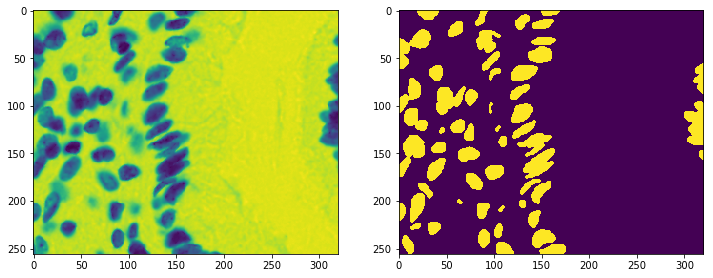

Image #: 521. Image Sizes: (256, 256) (256, 256)


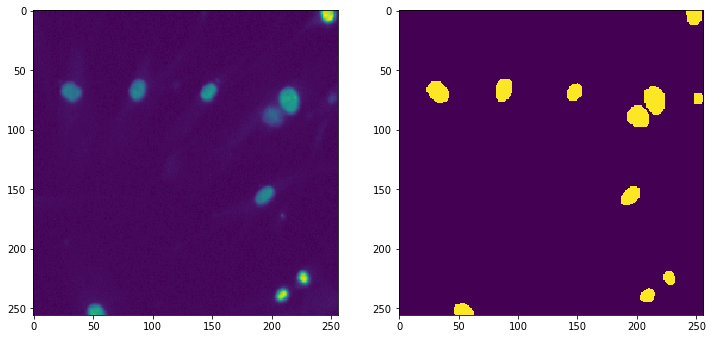

Image #: 389. Image Sizes: (256, 320) (256, 320)


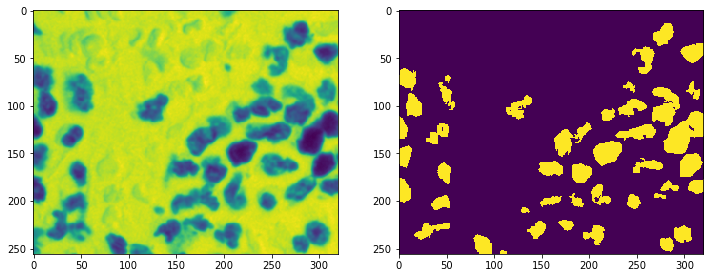

In [130]:
# Plot a training test and mask image side by side
def plot_side_by_side(image_ds,mask_ds,image_num):
    print('Image #: ' + str(image_num) + '. Image Sizes: ' + str(image_ds[image_num].shape) + ' ' + str(mask_ds[image_num].shape))
    fig = plt.figure(figsize=(12,12))
    ax1 = fig.add_subplot(1,2,1)
    ax1.imshow(image_ds[image_num])
    ax2 = fig.add_subplot(1,2,2)
    ax2.imshow(mask_ds[image_num])
    plt.show()
    
# Plots random corresponding images and masks
def plot_check(images,masks,rand_imgs=None,img_nums=None):
    if rand_imgs != None:
        for i in range(rand_imgs):
            plot_side_by_side(images,masks,randint(0,len(images)-1))
    if img_nums != None:
        for i in range(len(img_nums)):
            plot_side_by_side(images,masks,img_nums[i])
    
#plot_side_by_side(train_images,train_mask_images,38)
# Plot a few random images 
plot_check(train_images,train_mask_images,rand_imgs=3)



In [162]:
# Resize everything
#resized_train_images = [ resize(image,image_size) for image in train_images] 
#resized_train_mask_images = [ resize(image,image_size) for image in train_mask_images] 
crop_size=64

resized_train_images = [ image[int(0.5*(image.shape[0]-crop_size)):int(0.5*(image.shape[0]+crop_size)),
   int(0.5*(image.shape[1]-crop_size)):int(0.5*(image.shape[1]+crop_size))] for image in train_images] 

resized_train_mask_images = [ image[int(0.5*(image.shape[0]-crop_size)):int(0.5*(image.shape[0]+crop_size)),
   int(0.5*(image.shape[1]-crop_size)):int(0.5*(image.shape[1]+crop_size))] for image in train_mask_images] 

#resized_train_mask_images = [ image[0.5*(image.shape[0]-crop_size):0.5*(image.shape[0]+crop_size)] for image in train_mask_images] 



In [155]:
#for i in range(len(train_images)):
#    print(train_images[i].shape)

a= int(train_images[3].shape[0] /2)



train_images[3][a - 32:train_images[3].shape[0],].shape

(160, 320)

Image #: 350. Image Sizes: (64, 64) (64, 64)


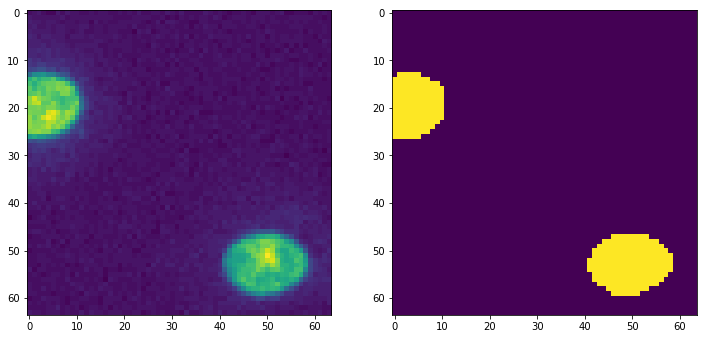

Image #: 243. Image Sizes: (64, 64) (64, 64)


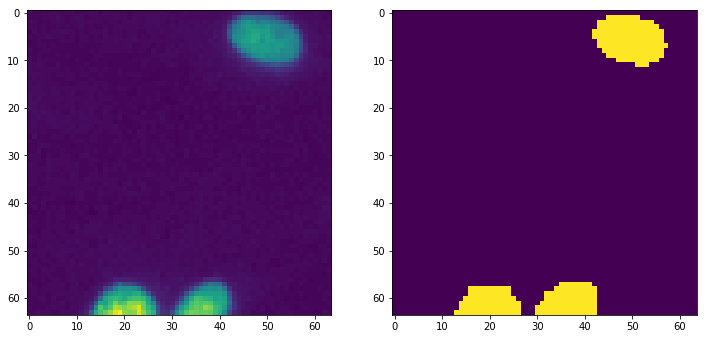

Image #: 652. Image Sizes: (64, 64) (64, 64)


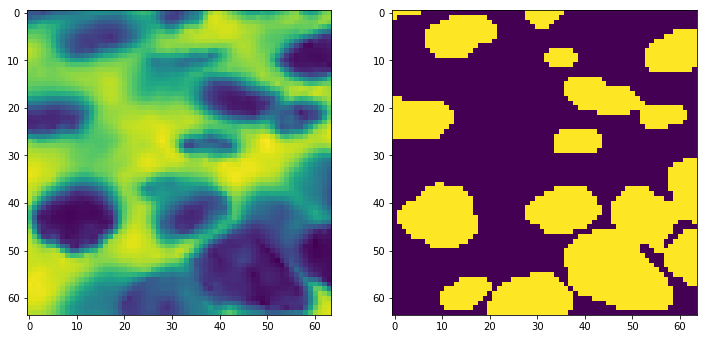

Image #: 527. Image Sizes: (64, 64) (64, 64)


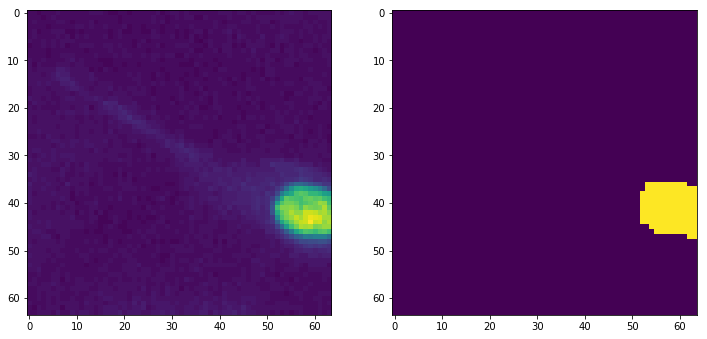

Image #: 16. Image Sizes: (64, 64) (64, 64)


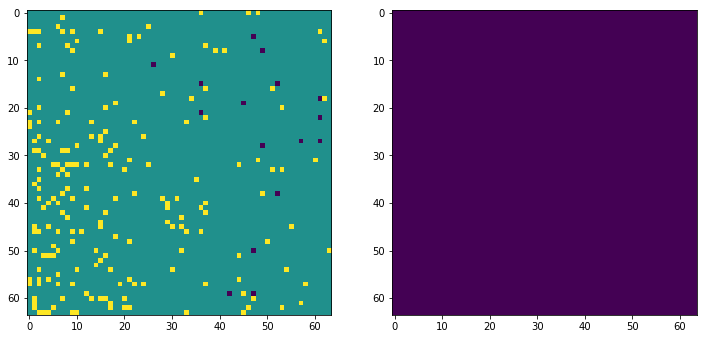

Image #: 311. Image Sizes: (64, 64) (64, 64)


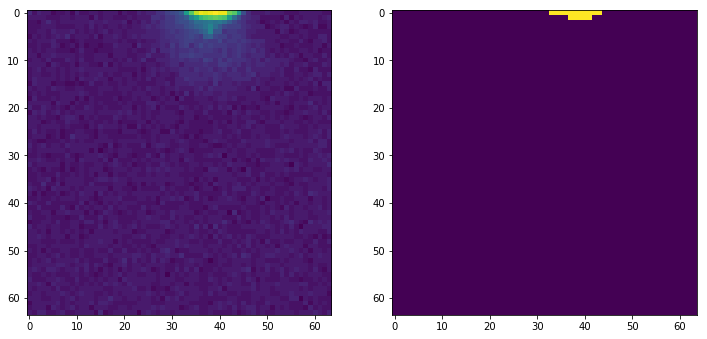

Image #: 647. Image Sizes: (64, 64) (64, 64)


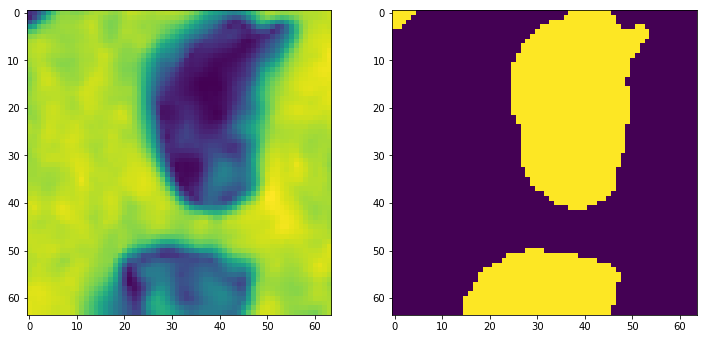

Image #: 311. Image Sizes: (64, 64) (64, 64)


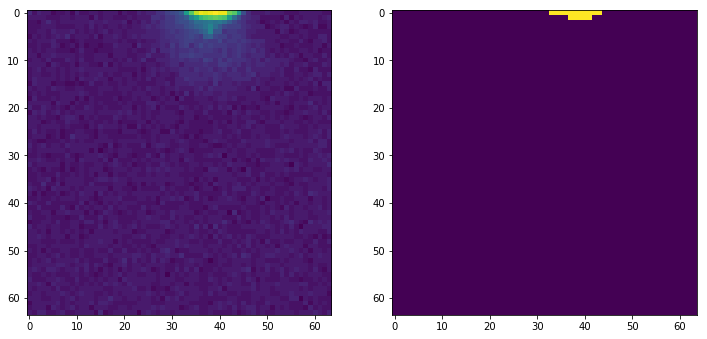

Image #: 243. Image Sizes: (64, 64) (64, 64)


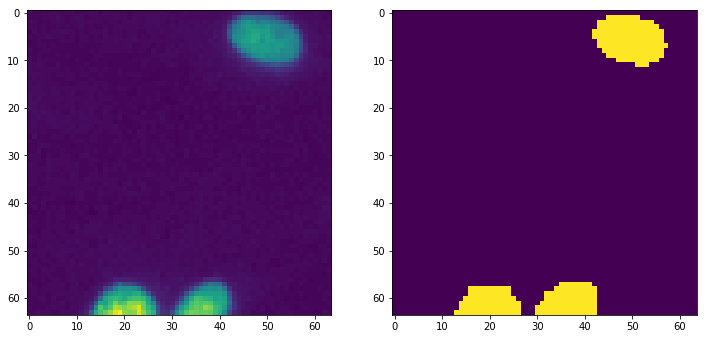

Image #: 463. Image Sizes: (64, 64) (64, 64)


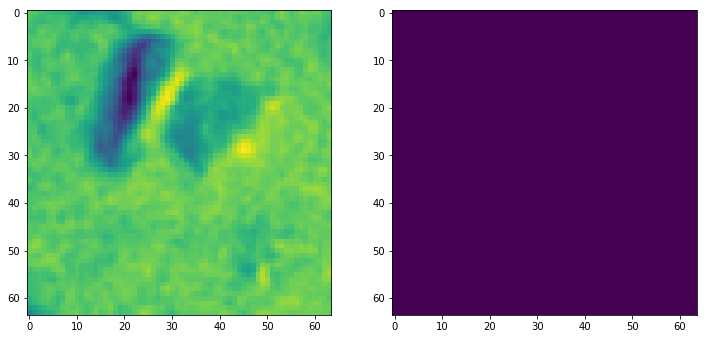

In [165]:
# Plot some resized images
plot_check(resized_train_images,resized_train_mask_images,rand_imgs=10)

In [91]:
# Shuffle images and masks in same way
import random

all_train = list(zip(resized_train_images,resized_train_mask_images))

random.shuffle(all_train)

shuffled_train_images, shuffled_train_mask_images = zip(*all_train)



Image #: 646. Image Sizes: (256, 256) (256, 256)


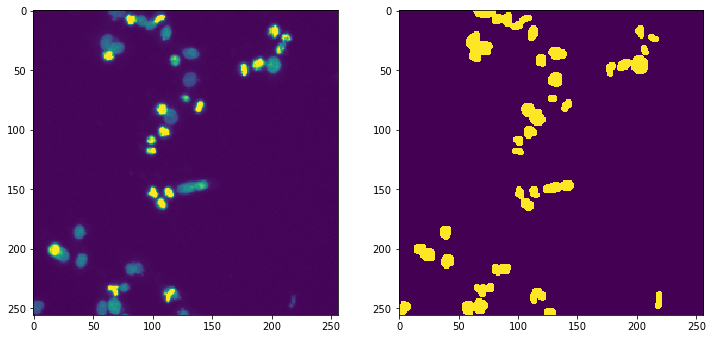

Image #: 456. Image Sizes: (256, 256) (256, 256)


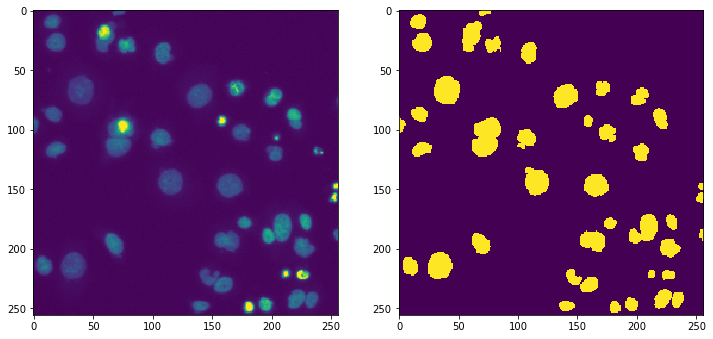

Image #: 588. Image Sizes: (256, 256) (256, 256)


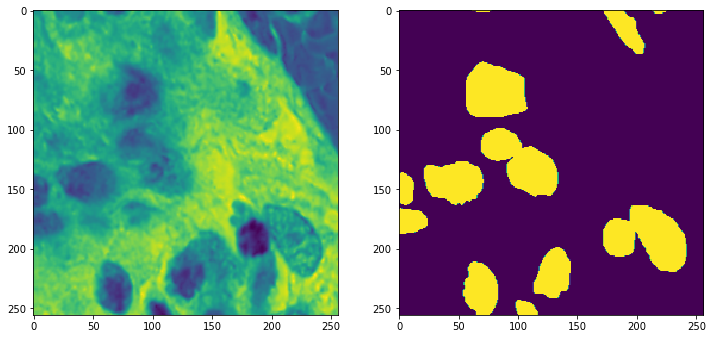

Image #: 57. Image Sizes: (256, 256) (256, 256)


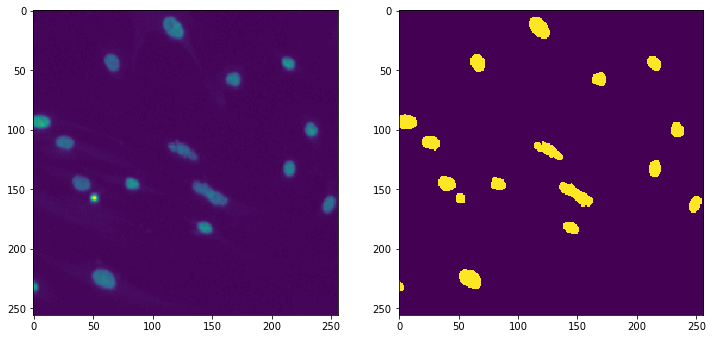

Image #: 516. Image Sizes: (256, 256) (256, 256)


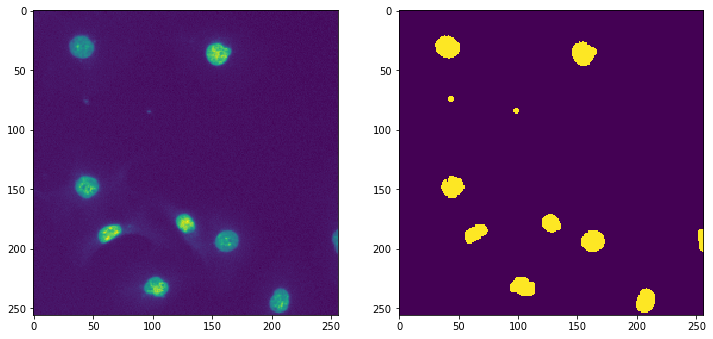

In [92]:
plot_check(shuffled_train_images,shuffled_train_mask_images,5)

In [93]:
# Reshape model inputs
train_X = np.reshape(np.array(shuffled_train_images),(670,256,256,1))
train_Y = np.reshape(np.array(shuffled_train_mask_images),(670,256,256,1))

print(train_X.shape)
print(train_Y.shape)

(670, 256, 256, 1)
(670, 256, 256, 1)


# Now Let's Build a Neural Net

In [96]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def bce_logdice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - K.log(1. - dice_loss(y_true, y_pred))

def weighted_bce_loss(y_true, y_pred, weight):
    epsilon = 1e-7
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    logit_y_pred = K.log(y_pred / (1. - y_pred))
    loss = weight * (logit_y_pred * (1. - y_true) + 
                     K.log(1. + K.exp(-K.abs(logit_y_pred))) + K.maximum(-logit_y_pred, 0.))
    return K.sum(loss) / K.sum(weight)

def weighted_dice_loss(y_true, y_pred, weight):
    smooth = 1.
    w, m1, m2 = weight, y_true, y_pred
    intersection = (m1 * m2)
    score = (2. * K.sum(w * intersection) + smooth) / (K.sum(w * m1) + K.sum(w * m2) + smooth)
    loss = 1. - K.sum(score)
    return loss

def weighted_bce_dice_loss(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    # if we want to get same size of output, kernel size must be odd
    averaged_mask = K.pool2d(
            y_true, pool_size=(50, 50), strides=(1, 1), padding='same', pool_mode='avg')
    weight = K.ones_like(averaged_mask)
    w0 = K.sum(weight)
    weight = 5. * K.exp(-5. * K.abs(averaged_mask - 0.5))
    w1 = K.sum(weight)
    weight *= (w0 / w1)
    loss = weighted_bce_loss(y_true, y_pred, weight) + dice_loss(y_true, y_pred)
    return loss

### for down side of U-net
def encoder(x, filters=16, n_block=2, kernel_size=(3, 3), activation='relu'):
    skip = []
    for i in range(n_block):
        x = Conv2D(filters * 2**i, kernel_size, activation=activation, padding='same')(x)
        x = Conv2D(filters * 2**i, kernel_size, activation=activation, padding='same')(x)
        skip.append(x)
        x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    return x, skip

### for center of U-net
def bottleneck(x, filters_bottleneck, depth=3,
               kernel_size=(3, 3), activation='relu'):
    dilated_layers = []
    for i in range(depth):
        dilated_layers.append(Conv2D(filters_bottleneck, kernel_size,
                       activation=activation, padding='same', dilation_rate=2**i)(x))
    return add(dilated_layers)

### for upside of U-net
def decoder(x, skip, filters, n_block=2, kernel_size=(3, 3), activation='relu'):
    for i in reversed(range(n_block)):
        x = UpSampling2D(size=(2, 2))(x)
        x = Conv2D(filters * 2**i, kernel_size, activation=activation, padding='same')(x)
        x = concatenate([skip[i], x])
        x = Conv2D(filters * 2**i, kernel_size, activation=activation, padding='same')(x)
        x = Conv2D(filters * 2**i, kernel_size, activation=activation, padding='same')(x)
    return x

## master function for creating a unet
def get_dilated_unet(
        input_shape=(256, 256,1),
        filters=16,
        n_block=3,
        lr=0.0015,
        loss=bce_dice_loss,
        n_class=1
):
    inputs = Input(input_shape)
    
    enc, skip = encoder(inputs, filters, n_block)
    bottle = bottleneck(enc, depth=3, filters_bottleneck=filters * 2**n_block)
    dec = decoder(bottle, skip, filters, n_block)
    classify = Conv2D(1,(1,1),activation='sigmoid')(dec)

    model = Model(inputs=inputs, outputs=classify)
    model.compile(optimizer=RMSprop(lr), loss=loss, metrics=[dice_coef, binary_crossentropy])

    return model

In [97]:
my_model = get_dilated_unet()

In [98]:
print(my_model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 16) 2320        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 128, 128, 16) 0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

In [99]:
# check length and shape
print(len(resized_train_images))
print(len(resized_train_mask_images))
print(np.array(resized_train_images).shape)
print(resized_train_mask_images[669].shape)
# looks good

670
670
(670, 256, 256)
(256, 256)


In [101]:
print(train_Y.nbytes)
print(train_X.nbytes)

351272960
351272960


Image #: 551. Image Sizes: (256, 256) (256, 256)


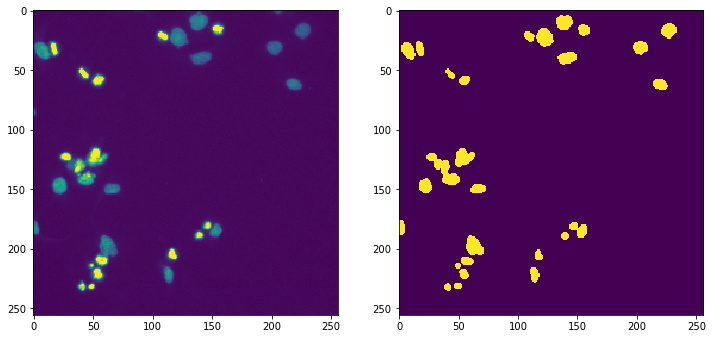

Image #: 551. Image Sizes: (256, 256) (256, 256)


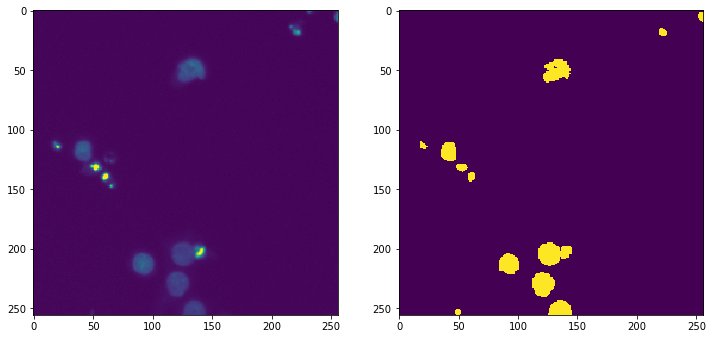

In [103]:
# Check numpy array
plot_side_by_side(np.squeeze(train_X,axis=3),np.squeeze(train_Y,axis=3),551)
plot_side_by_side(resized_train_images,resized_train_mask_images,551)

In [104]:
# Fit model

# Implement learning rate decay https://keras.io/callbacks/#learningratescheduler 

earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint(model_checkpoint_file, verbose=1, save_best_only=True)
reduce_plateau = ReduceLROnPlateau(monitor='val_loss', 
                           factor=0.5,
                           patience=3,
                           verbose=1,
                           mode='auto') 
# verbose=2 => one line per epoch, 1 = progress bar
results = my_model.fit(train_X, train_Y, validation_split=0.1, batch_size=20, epochs=50, verbose=1 , 
                    callbacks=[earlystopper, checkpointer, reduce_plateau])

Train on 603 samples, validate on 67 samples
Epoch 1/50
600/603 [============================>.] - ETA: 3s - loss: 1.4594 - dice_coef: 0.0064 - binary_crossentropy: 0.6521 
Epoch 00001: val_loss improved from inf to 1.08967, saving model to bw_model_v1.h5
603/603 [==============================] - 653s 1s/step - loss: 1.4563 - dice_coef: 0.0063 - binary_crossentropy: 0.6498 - val_loss: 1.0897 - val_dice_coef: 0.0000e+00 - val_binary_crossentropy: 0.3877
Epoch 2/50
600/603 [============================>.] - ETA: 3s - loss: 0.9219 - dice_coef: 0.1498 - binary_crossentropy: 0.2947 
Epoch 00002: val_loss improved from 1.08967 to 0.76900, saving model to bw_model_v1.h5
603/603 [==============================] - 646s 1s/step - loss: 0.9207 - dice_coef: 0.1525 - binary_crossentropy: 0.2941 - val_loss: 0.7690 - val_dice_coef: 0.6977 - val_binary_crossentropy: 0.2010
Epoch 3/50
600/603 [============================>.] - ETA: 3s - loss: 0.9955 - dice_coef: 0.5889 - binary_crossentropy: 0.4475 
E

Epoch 00021: early stopping


In [ ]:
Ideas
 - Check size of mask and image arrays - should be able to compress mask since it is 1/0
    are we seeing a performance benefit vs color???
- Crop images to 64x64 to train networks faster for testing ??
- Shuffle images
- Is combining the masks really the best thing to do? Should I be keeping the individual cells separate?